In [25]:
import numpy as np
import matplotlib.pyplot as plt

from utilidades import conectar_db
from utilidades import reducir_dimensionalidad_dataset
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [26]:
connection = conectar_db()
df_reducido = reducir_dimensionalidad_dataset()
df_reducido_estadisticas = df_reducido.iloc[:,2:]

[pca] >Processing dataframe..
[pca] >Normalizing input data per feature (zero mean and unit variance)..
[pca] >The PCA reduction is performed on the [67] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[11]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]
[pca] >Processing dataframe..
[pca] >Normalizing input data per feature (zero mean and unit variance)..
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[11]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


## Aplicación de Clustering al dataset completo

In [27]:
def obtener_dataset_segun_posicion(posicion_jugador, dataset):
    return dataset[dataset["posicion"] == posicion_jugador]

def graficar_metodo_del_codo(dataset):
    wcss = []

    for i in range(1,13):
        kmeans = KMeans(n_clusters=i, max_iter=300, n_init='auto')
        kmeans.fit(dataset)
        wcss.append(kmeans.inertia_)

    plt.plot(range(1,13), wcss)
    plt.title("Gráfico del Codo")
    plt.xlabel("Nro de clusters")
    plt.ylabel("WCSS")
    plt.show()


def graficar_analisis_silueta(dataset):
    silueta = []
    K = range(2,13)

    for i in K:
        kmeans = KMeans(n_clusters=i, max_iter=300, n_init='auto')
        kmeans.fit(dataset)
        labels = kmeans.labels_

        silueta.append(silhouette_score(dataset, labels, metric='euclidean'))

    plt.plot(K, silueta, 'bx-')
    plt.xlabel('Clusteres')
    plt.ylabel('Puntaje de la silueta')
    plt.title('Metodo de la silueta')
    plt.show()
    

### Grafico del codo al dataset completo

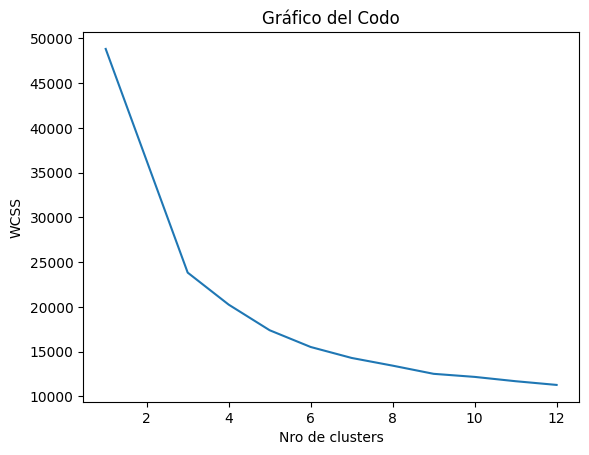

In [28]:
graficar_metodo_del_codo(df_reducido_estadisticas)

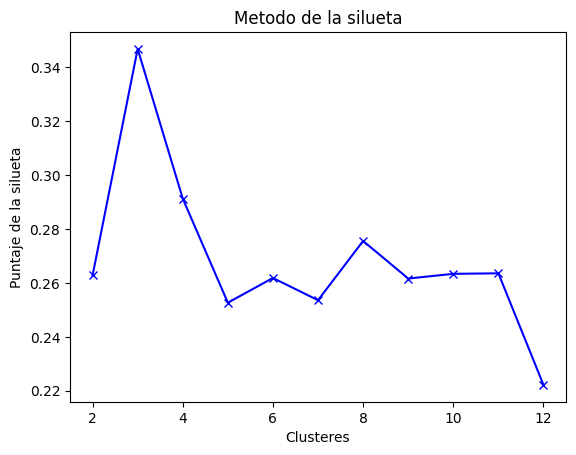

In [29]:
graficar_analisis_silueta(df_reducido_estadisticas)

### Aplicar el metodo kmeans al dataset

In [33]:
kmeans = KMeans(n_clusters=4, n_init='auto')
kmeans.fit(df_reducido_estadisticas)
df_reducido_completo = df_reducido.copy(deep=True)
df_reducido_completo["cluster"] = kmeans.labels_
df_reducido_completo.head(40)

,jugador_id,posicion,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,cluster
0,1,Portero,11.497751,3.764486,3.165575,1.060991,0.004271,-0.261821,-0.372052,0.075543,0.010033,-0.267192,0.124301,1
1,2,Portero,11.832282,2.861687,2.119234,0.540186,0.321307,0.241788,-0.058070,0.016331,0.247164,0.051287,0.329480,1
2,3,Defensor,-5.667197,2.324102,4.789676,-0.481784,-0.958690,-0.520618,0.448441,-1.290865,1.595958,-0.179503,-0.923210,0
3,4,Defensor,-1.782642,-0.007719,1.185804,-0.628824,0.807810,-0.935910,0.831182,-2.275046,0.762425,0.044163,0.167929,0
4,5,Defensor,-4.295145,-0.601999,3.523056,-1.499500,2.698427,-2.249652,1.092824,-2.417624,1.258301,-0.649061,1.201315,0
5,6,Defensor,-0.591783,5.997345,-3.239799,0.304490,-0.535613,-0.943465,0.720608,0.383197,0.801827,0.887423,1.483486,3
6,7,Defensor,-2.566821,4.630466,-1.335874,1.316481,-0.790933,-2.948861,-0.302823,1.269271,0.612603,-1.150589,-0.696622,3
7,8,Defensor,-1.398874,7.149251,-1.478345,0.431958,-0.935718,-2.211925,2.786283,2.812772,0.666853,-2.150658,-0.246273,3
8,9,Defensor,-5.015046,6.899355,0.038615,2.147793,-0.673567,-0.856316,0.579779,0.683450,-0.143131,-0.213508,0.151698,3
9,10,Defensor,-5.658110,8.639655,2.053498,2.345187,-2.956318,-3.071687,-0.212539,0.951692,-0.437433,0.556636,-0.585276,3


#### Analisis de resultados segun posiciones

In [34]:
def resultados_obtenidos_segun_posicion(posicion, dataset):
    df_segun_posicion = obtener_dataset_segun_posicion(posicion,dataset)
    return df_segun_posicion.groupby('cluster').size()

In [35]:
resultados_obtenidos_segun_posicion('Portero', df_reducido_completo)

cluster
1    67
dtype: int64

In [36]:
resultados_obtenidos_segun_posicion('Defensor', df_reducido_completo)

cluster
0     91
2      6
3    160
dtype: int64

In [37]:
resultados_obtenidos_segun_posicion('Mediocampista', df_reducido_completo)

cluster
0    98
2    87
3    86
dtype: int64

In [38]:
resultados_obtenidos_segun_posicion('Delantero', df_reducido_completo)

cluster
0     38
2    163
3      3
dtype: int64

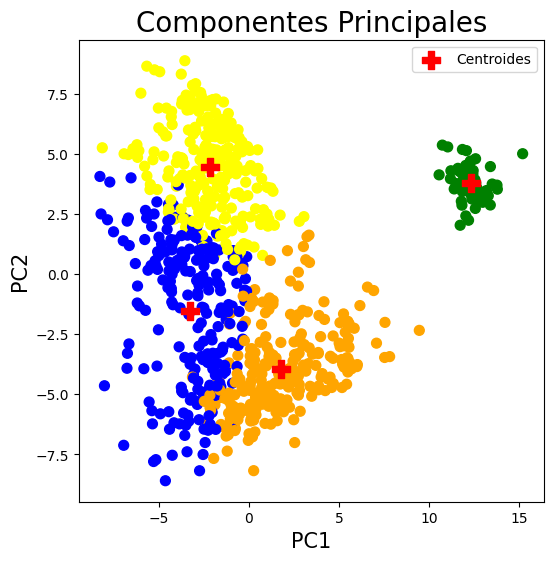

In [39]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('PC1',fontsize=15)
ax.set_ylabel('PC2',fontsize=15)
ax.set_title('Componentes Principales', fontsize=20)

color_theme = np.array(['blue','green','orange','yellow'])
ax.scatter(x=df_reducido_completo['PC1'].values, y=df_reducido_completo['PC2'].values, 
           c=color_theme[df_reducido_completo['cluster']], s=50)

# Obtener y graficar centroides
centroids = kmeans.cluster_centers_
ax.scatter(x=centroids[:, 0], y=centroids[:, 1], 
           marker='P', s=180, color='red', label='Centroides')

ax.legend()
plt.show()

In [40]:
def buscar_cluster_jugador(jugador_id, dataset):
    datos_jugador_seleccionado = dataset[dataset['jugador_id'] == jugador_id]
    return datos_jugador_seleccionado['cluster'][jugador_id-1]

buscar_cluster_jugador(153,df_reducido_completo)

0

## Aplicación del Clustering al dataset de Defensores

In [16]:
df_defensores = obtener_dataset_segun_posicion('Defensor', df_reducido)
df_defensores

,jugador_id,posicion,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11
2,3,Defensor,-5.667197,2.324102,4.789676,-0.481784,-0.958693,-0.520615,0.448454,-1.290898,1.596245,-0.179310,-0.923048
3,4,Defensor,-1.782642,-0.007719,1.185804,-0.628824,0.807809,-0.935909,0.831188,-2.275066,0.762567,0.044164,0.168000
4,5,Defensor,-4.295145,-0.601999,3.523056,-1.499500,2.698427,-2.249653,1.092829,-2.417633,1.258251,-0.649110,1.201227
5,6,Defensor,-0.591783,5.997345,-3.239799,0.304490,-0.535612,-0.943464,0.720601,0.383217,0.801736,0.887430,1.483419
6,7,Defensor,-2.566821,4.630466,-1.335874,1.316481,-0.790933,-2.948861,-0.302825,1.269286,0.612634,-1.150427,-0.696490
...,...,...,...,...,...,...,...,...,...,...,...,...,...
781,782,Defensor,-3.498257,0.126943,2.256947,-2.645054,2.690736,-2.138953,-0.997634,0.325234,1.249176,0.141678,-1.052737
782,783,Defensor,-4.250365,6.212864,3.020641,0.826501,-0.875771,-0.548520,3.850024,1.636520,-0.937666,1.997066,-0.374040
783,784,Defensor,-1.749639,3.615979,-1.465426,-0.845497,-0.097073,0.978794,-0.590736,0.875162,-0.581952,-0.586436,-0.318752
784,785,Defensor,-2.712303,3.710827,0.144010,-0.381454,1.181294,0.628798,-0.637481,-3.339085,-1.077808,-0.623086,2.202690


In [17]:
df_defensores_estadisticas = df_defensores.iloc[:, 2:]
df_defensores_estadisticas

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11
2,-5.667197,2.324102,4.789676,-0.481784,-0.958693,-0.520615,0.448454,-1.290898,1.596245,-0.179310,-0.923048
3,-1.782642,-0.007719,1.185804,-0.628824,0.807809,-0.935909,0.831188,-2.275066,0.762567,0.044164,0.168000
4,-4.295145,-0.601999,3.523056,-1.499500,2.698427,-2.249653,1.092829,-2.417633,1.258251,-0.649110,1.201227
5,-0.591783,5.997345,-3.239799,0.304490,-0.535612,-0.943464,0.720601,0.383217,0.801736,0.887430,1.483419
6,-2.566821,4.630466,-1.335874,1.316481,-0.790933,-2.948861,-0.302825,1.269286,0.612634,-1.150427,-0.696490
...,...,...,...,...,...,...,...,...,...,...,...
781,-3.498257,0.126943,2.256947,-2.645054,2.690736,-2.138953,-0.997634,0.325234,1.249176,0.141678,-1.052737
782,-4.250365,6.212864,3.020641,0.826501,-0.875771,-0.548520,3.850024,1.636520,-0.937666,1.997066,-0.374040
783,-1.749639,3.615979,-1.465426,-0.845497,-0.097073,0.978794,-0.590736,0.875162,-0.581952,-0.586436,-0.318752
784,-2.712303,3.710827,0.144010,-0.381454,1.181294,0.628798,-0.637481,-3.339085,-1.077808,-0.623086,2.202690


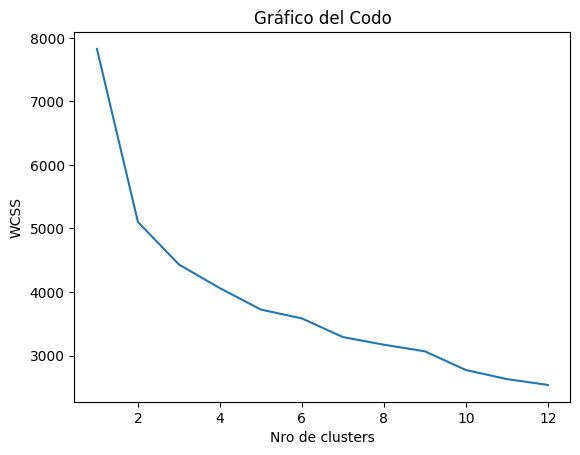

In [18]:
graficar_metodo_del_codo(df_defensores_estadisticas)

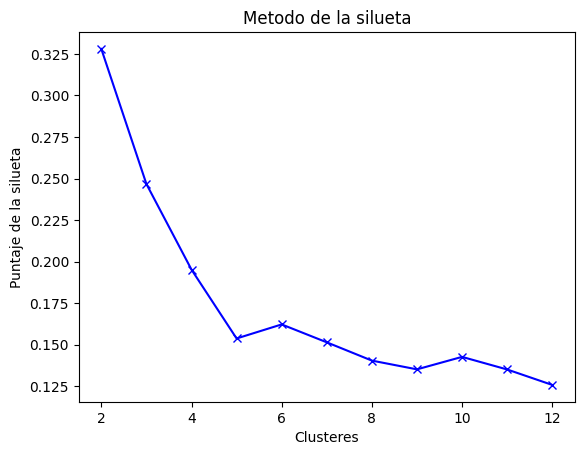

In [19]:
graficar_analisis_silueta(df_defensores_estadisticas)

In [20]:
clustering_defensas = KMeans(n_clusters=2, max_iter=300, n_init='auto')
clustering_defensas.fit(df_defensores_estadisticas)
centroides = clustering_defensas.cluster_centers_
centroides

array([[-1.85002988e+00,  5.70693609e+00, -2.13122776e+00,
         7.03605078e-01, -3.04158346e-03, -1.10904518e+00,
         6.44983624e-01,  7.25682611e-01, -1.48189502e-01,
         2.47495966e-01,  3.65394226e-01],
       [-3.08073360e+00,  1.27352358e+00,  1.30760790e+00,
        -1.23081988e+00,  1.37040014e+00, -5.74819490e-01,
        -1.01277004e-01, -8.00449596e-01,  2.13525160e-01,
        -1.35887313e-01, -2.00850566e-01]])

In [21]:
df_defensores["cluster"] = clustering_defensas.labels_
df_defensores.head(20)

/var/folders/cf/8vfv4bt148dgh61c40z4wnvh0000gn/T/ipykernel_2356/1338970559.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_defensores["cluster"] = clustering_defensas.labels_


,jugador_id,posicion,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,cluster
2,3,Defensor,-5.667197,2.324102,4.789676,-0.481784,-0.958693,-0.520615,0.448454,-1.290898,1.596245,-0.179310,-0.923048,1
3,4,Defensor,-1.782642,-0.007719,1.185804,-0.628824,0.807809,-0.935909,0.831188,-2.275066,0.762567,0.044164,0.168000,1
4,5,Defensor,-4.295145,-0.601999,3.523056,-1.499500,2.698427,-2.249653,1.092829,-2.417633,1.258251,-0.649110,1.201227,1
5,6,Defensor,-0.591783,5.997345,-3.239799,0.304490,-0.535612,-0.943464,0.720601,0.383217,0.801736,0.887430,1.483419,0
6,7,Defensor,-2.566821,4.630466,-1.335874,1.316481,-0.790933,-2.948861,-0.302825,1.269286,0.612634,-1.150427,-0.696490,0
7,8,Defensor,-1.398874,7.149251,-1.478345,0.431959,-0.935723,-2.211919,2.786281,2.812772,0.667215,-2.150258,-0.246171,0
8,9,Defensor,-5.015046,6.899355,0.038615,2.147794,-0.673571,-0.856309,0.579786,0.683427,-0.142735,-0.213170,0.151882,0
9,10,Defensor,-5.658110,8.639655,2.053498,2.345188,-2.956324,-3.071681,-0.212523,0.951641,-0.436890,0.556885,-0.585008,0
10,11,Defensor,-5.985816,7.517400,0.900838,1.889391,-1.008298,0.081766,-0.080496,2.224536,-0.749645,1.944188,1.015307,0
11,12,Defensor,-6.187045,-1.204665,4.426928,-0.470724,3.161174,-1.222810,0.300848,0.222487,0.296137,-0.953072,-0.579486,1


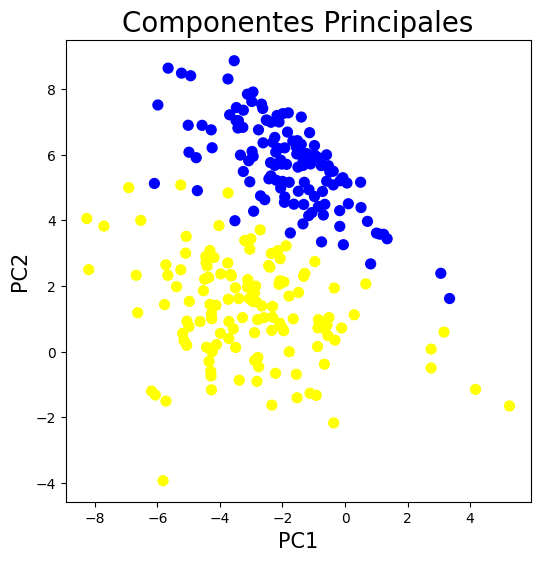

In [22]:
fig = plt.figure(figsize=(6,6))

ax = fig.add_subplot(1,1,1)
ax.set_xlabel('PC1',fontsize=15)
ax.set_ylabel('PC2',fontsize=15)
ax.set_title('Componentes Principales', fontsize=20)

color_theme = np.array(['blue','yellow'])
ax.scatter(x=df_defensores['PC1'].values, y=df_defensores['PC2'].values, c=color_theme[df_defensores['cluster']], s=50)

plt.show()

## Aplicación de Clustering al dataset de Delanteros

In [23]:
df_delanteros = obtener_dataset_segun_posicion('Delantero', df_reducido)
df_delanteros

,jugador_id,posicion,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11
25,26,Delantero,-2.729279,-8.178145,1.704982,3.579944,0.500650,-0.285804,0.873798,-0.785126,-0.122875,0.733892,1.455270
26,27,Delantero,-1.016001,-5.748364,-1.220676,2.804090,-0.183317,0.530429,-0.270747,-0.424616,0.584257,-0.102598,1.244368
27,28,Delantero,-3.424206,-7.390166,3.884525,3.144896,-2.058444,-1.907666,1.713178,-1.790114,0.383631,-0.392384,1.281682
51,52,Delantero,5.705456,-3.939280,-4.145206,-0.619797,-1.899985,-0.684320,0.119825,-1.467515,0.458053,-0.825717,-0.075328
52,53,Delantero,5.250123,-3.650193,-1.576102,-3.037851,-1.043861,-1.085648,0.848736,-0.050271,-0.897851,0.355831,-0.068156
...,...,...,...,...,...,...,...,...,...,...,...,...,...
794,795,Delantero,-0.601124,-6.053920,-2.294790,4.541113,-0.160305,0.641348,1.045621,0.013166,0.400690,1.044791,-0.008819
795,796,Delantero,4.532503,-3.419093,-2.098139,-2.159164,-0.953598,-0.991364,0.615725,-0.923017,-0.167553,0.071455,-0.154133
796,797,Delantero,0.070015,-3.701620,-2.964631,2.124170,0.502705,-0.315402,-0.145809,-0.646738,-0.032311,-1.119268,-1.531811
797,798,Delantero,2.542480,-3.351397,-2.197663,-0.577659,-0.660660,-0.187664,-0.102389,-0.334996,-0.093604,0.494609,-0.678576


In [24]:
df_delanteros_estadisticas = df_delanteros.iloc[:, 2:]
df_delanteros_estadisticas

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11
25,-2.729279,-8.178145,1.704982,3.579944,0.500650,-0.285804,0.873798,-0.785126,-0.122875,0.733892,1.455270
26,-1.016001,-5.748364,-1.220676,2.804090,-0.183317,0.530429,-0.270747,-0.424616,0.584257,-0.102598,1.244368
27,-3.424206,-7.390166,3.884525,3.144896,-2.058444,-1.907666,1.713178,-1.790114,0.383631,-0.392384,1.281682
51,5.705456,-3.939280,-4.145206,-0.619797,-1.899985,-0.684320,0.119825,-1.467515,0.458053,-0.825717,-0.075328
52,5.250123,-3.650193,-1.576102,-3.037851,-1.043861,-1.085648,0.848736,-0.050271,-0.897851,0.355831,-0.068156
...,...,...,...,...,...,...,...,...,...,...,...
794,-0.601124,-6.053920,-2.294790,4.541113,-0.160305,0.641348,1.045621,0.013166,0.400690,1.044791,-0.008819
795,4.532503,-3.419093,-2.098139,-2.159164,-0.953598,-0.991364,0.615725,-0.923017,-0.167553,0.071455,-0.154133
796,0.070015,-3.701620,-2.964631,2.124170,0.502705,-0.315402,-0.145809,-0.646738,-0.032311,-1.119268,-1.531811
797,2.542480,-3.351397,-2.197663,-0.577659,-0.660660,-0.187664,-0.102389,-0.334996,-0.093604,0.494609,-0.678576


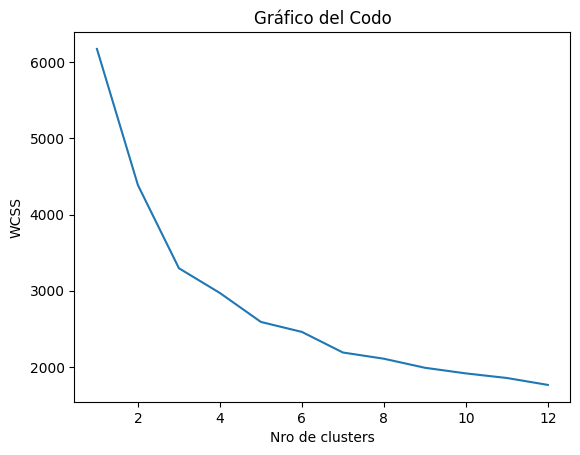

In [25]:
graficar_metodo_del_codo(df_delanteros_estadisticas)

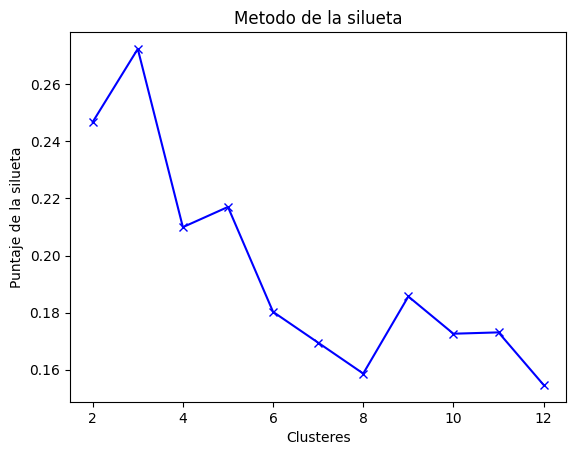

In [26]:
graficar_analisis_silueta(df_delanteros_estadisticas)

In [27]:
clustering_delanteros = KMeans(n_clusters=3, max_iter=300, n_init='auto')
clustering_delanteros.fit(df_delanteros_estadisticas)
centroides = clustering_delanteros.cluster_centers_
centroides

array([[-1.91207367, -5.28016851,  1.44038136,  0.45332056,  0.6536298 ,
        -0.21970033,  0.05499025,  0.62122477,  0.26406994,  0.17220636,
         0.39210016],
       [ 3.63820546, -3.85841715, -2.21983743, -1.37985037, -0.37667104,
        -0.38044078,  0.36900202, -0.06493686, -0.30771244,  0.05719386,
         0.06593088],
       [ 0.14593056, -5.08989437, -2.99466653,  3.48213043, -0.15238699,
         0.02440389, -0.30460276, -0.55874413,  0.32678962, -0.26620666,
        -0.20143132]])

In [28]:
df_delanteros["cluster"] = clustering_delanteros.labels_
df_delanteros.head(20)

/var/folders/cf/8vfv4bt148dgh61c40z4wnvh0000gn/T/ipykernel_2356/3116596761.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_delanteros["cluster"] = clustering_delanteros.labels_


,jugador_id,posicion,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,cluster
25,26,Delantero,-2.729279,-8.178145,1.704982,3.579944,0.500650,-0.285804,0.873798,-0.785126,-0.122875,0.733892,1.455270,0
26,27,Delantero,-1.016001,-5.748364,-1.220676,2.804090,-0.183317,0.530429,-0.270747,-0.424616,0.584257,-0.102598,1.244368,2
27,28,Delantero,-3.424206,-7.390166,3.884525,3.144896,-2.058444,-1.907666,1.713178,-1.790114,0.383631,-0.392384,1.281682,0
51,52,Delantero,5.705456,-3.939280,-4.145206,-0.619797,-1.899985,-0.684320,0.119825,-1.467515,0.458053,-0.825717,-0.075328,1
52,53,Delantero,5.250123,-3.650193,-1.576102,-3.037851,-1.043861,-1.085648,0.848736,-0.050271,-0.897851,0.355831,-0.068156,1
53,54,Delantero,-2.534034,-7.502130,1.706396,3.707522,0.469464,0.607064,2.982328,-0.959630,0.318758,2.474493,0.331797,0
54,55,Delantero,-0.737994,-6.421779,-2.757953,4.555310,0.366458,0.381542,0.046248,-0.954884,1.279676,0.865473,0.630529,2
55,56,Delantero,-3.741361,-4.707607,1.173891,-0.358888,2.251597,0.487356,-1.084893,-0.581093,2.394356,-0.665036,0.087448,0
72,73,Delantero,2.855723,-5.705446,-1.049965,0.665970,-1.801769,-0.477101,1.526313,-0.409014,-0.369513,0.829786,0.473201,1
73,74,Delantero,4.078370,-4.139949,-3.810022,0.238376,-0.817593,0.076506,0.046385,-1.079229,0.693400,0.467970,0.160616,1


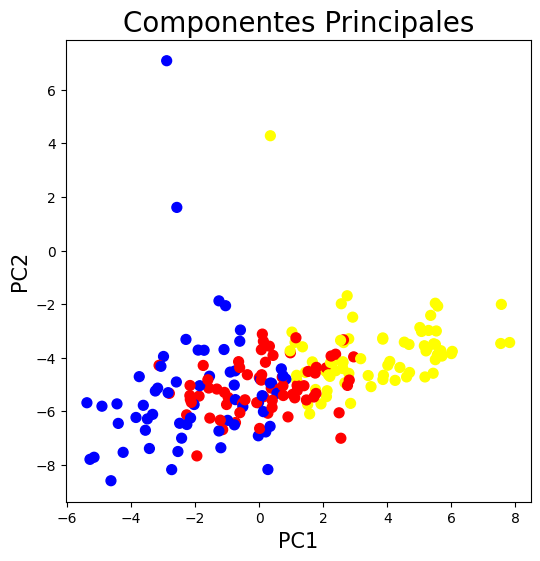

In [29]:
fig = plt.figure(figsize=(6,6))

ax = fig.add_subplot(1,1,1)
ax.set_xlabel('PC1',fontsize=15)
ax.set_ylabel('PC2',fontsize=15)
ax.set_title('Componentes Principales', fontsize=20)

color_theme = np.array(['blue','yellow','red'])
ax.scatter(x=df_delanteros['PC1'].values, y=df_delanteros['PC2'].values, c=color_theme[df_delanteros['cluster']], s=50)

plt.show()